In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_excel('../Data/FINAL_data.xlsx', index_col='Timestamp', parse_dates=True)

features = [
    'pm25', 'pm10', 'pm25_24hr_avg', 'pm10_24hr_avg', 'pm25_lag1', 'pm10_lag1', 'pm25_change', 'pm10_change',
    'temp', 'visibility', 'dew_point', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_gust'
]


targets = ['pm25', 'pm10']

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [26]:
n_hours = 336
n_forecast_hours = 24
n_features = len(features)
data_prepared = series_to_supervised(data, n_hours, n_forecast_hours)

print(data_prepared.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8377 entries, 2023-01-16 01:00:00 to 2023-12-31 01:00:00
Columns: 6120 entries, var1(t-336) to var17(t+23)
dtypes: float64(6120)
memory usage: 391.2 MB
None


In [27]:
values = data_prepared.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

n_obs = n_hours * n_features
train_X_24h, train_y_24h = train[:, :n_obs], train[:, -n_forecast_hours * len(targets):]
test_X_24h, test_y_24h = test[:, :n_obs], test[:, -n_forecast_hours * len(targets):]

train_X_24h = train_X_24h.reshape((train_X_24h.shape[0], n_hours, n_features))
test_X_24h = test_X_24h.reshape((test_X_24h.shape[0], n_hours, n_features))

print("train_X shape:", train_X_24h.shape)
print("train_y shape:", train_y_24h.shape)
print("test_X shape:", test_X_24h.shape)
print("test_y shape:", test_y_24h.shape)

train_X shape: (6701, 336, 17)
train_y shape: (6701, 48)
test_X shape: (1676, 336, 17)
test_y shape: (1676, 48)


In [4]:
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(n_hours, n_features)))
model.add(LSTM(50, activation='tanh', return_sequences=True, recurrent_activation='sigmoid', kernel_initializer='glorot_uniform'))
model.add(LSTM(50, activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(n_forecast_hours * len(targets)))

2024-05-03 23:54:14.146552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])

In [6]:
model.fit(train_X_24h, train_y_24h, epochs=30, batch_size=72, validation_data=(test_X_24h, test_y_24h), verbose=2)

Epoch 1/30
94/94 - 38s - loss: 0.0429 - mae: 0.1352 - mse: 0.0429 - val_loss: 0.0374 - val_mae: 0.1307 - val_mse: 0.0374 - 38s/epoch - 408ms/step
Epoch 2/30
94/94 - 30s - loss: 0.0250 - mae: 0.0995 - mse: 0.0250 - val_loss: 0.0313 - val_mae: 0.1202 - val_mse: 0.0313 - 30s/epoch - 317ms/step
Epoch 3/30
94/94 - 29s - loss: 0.0208 - mae: 0.0861 - mse: 0.0208 - val_loss: 0.0273 - val_mae: 0.1101 - val_mse: 0.0273 - 29s/epoch - 313ms/step
Epoch 4/30
94/94 - 30s - loss: 0.0191 - mae: 0.0802 - mse: 0.0191 - val_loss: 0.0269 - val_mae: 0.1083 - val_mse: 0.0269 - 30s/epoch - 318ms/step
Epoch 5/30
94/94 - 30s - loss: 0.0182 - mae: 0.0777 - mse: 0.0182 - val_loss: 0.0293 - val_mae: 0.1145 - val_mse: 0.0293 - 30s/epoch - 315ms/step
Epoch 6/30
94/94 - 29s - loss: 0.0178 - mae: 0.0763 - mse: 0.0178 - val_loss: 0.0238 - val_mae: 0.1014 - val_mse: 0.0238 - 29s/epoch - 305ms/step
Epoch 7/30
94/94 - 29s - loss: 0.0173 - mae: 0.0748 - mse: 0.0173 - val_loss: 0.0279 - val_mae: 0.1089 - val_mse: 0.0279 - 2

In [8]:
model.save('24h_forecast_model.h5')
print("Model saved successfully.")

Model saved successfully.


In [28]:
n_hours = 24
n_forecast_hours = 2
n_features = len(features)
data_prepared = series_to_supervised(data, n_hours, n_forecast_hours)

print(data_prepared.info())


values = data_prepared.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

n_obs = n_hours * n_features
train_X_2h, train_y_2h = train[:, :n_obs], train[:, -n_forecast_hours * len(targets):]
test_X_2h, test_y_2h = test[:, :n_obs], test[:, -n_forecast_hours * len(targets):]

train_X_2h = train_X_2h.reshape((train_X_2h.shape[0], n_hours, n_features))
test_X_2h = test_X_2h.reshape((test_X_2h.shape[0], n_hours, n_features))

print("train_X shape:", train_X_2h.shape)
print("train_y shape:", train_y_2h.shape)
print("test_X shape:", test_X_2h.shape)
print("test_y shape:", test_y_2h.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8711 entries, 2023-01-03 01:00:00 to 2023-12-31 23:00:00
Columns: 442 entries, var1(t-24) to var17(t+1)
dtypes: float64(442)
memory usage: 29.4 MB
None
train_X shape: (6968, 24, 17)
train_y shape: (6968, 4)
test_X shape: (1743, 24, 17)
test_y shape: (1743, 4)


In [11]:
model1 = Sequential()
model1.add(Masking(mask_value=0.0, input_shape=(n_hours, n_features)))
model1.add(LSTM(50, activation='tanh', return_sequences=True, recurrent_activation='sigmoid', kernel_initializer='glorot_uniform'))
model1.add(LSTM(50, activation='tanh', recurrent_activation='sigmoid'))
model1.add(Dense(n_forecast_hours * len(targets)))


optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model1.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])

model1.fit(train_X_2h, train_y_2h, epochs=30, batch_size=72, validation_data=(test_X_2h, test_y_2h), verbose=2)

Epoch 1/30
97/97 - 8s - loss: 0.0320 - mae: 0.1180 - mse: 0.0320 - val_loss: 0.0218 - val_mae: 0.1069 - val_mse: 0.0218 - 8s/epoch - 84ms/step
Epoch 2/30
97/97 - 2s - loss: 0.0212 - mae: 0.0955 - mse: 0.0212 - val_loss: 0.0199 - val_mae: 0.1054 - val_mse: 0.0199 - 2s/epoch - 23ms/step
Epoch 3/30
97/97 - 2s - loss: 0.0172 - mae: 0.0820 - mse: 0.0172 - val_loss: 0.0160 - val_mae: 0.0892 - val_mse: 0.0160 - 2s/epoch - 22ms/step
Epoch 4/30
97/97 - 2s - loss: 0.0164 - mae: 0.0801 - mse: 0.0164 - val_loss: 0.0145 - val_mae: 0.0830 - val_mse: 0.0145 - 2s/epoch - 22ms/step
Epoch 5/30
97/97 - 2s - loss: 0.0157 - mae: 0.0777 - mse: 0.0157 - val_loss: 0.0147 - val_mae: 0.0853 - val_mse: 0.0147 - 2s/epoch - 22ms/step
Epoch 6/30
97/97 - 2s - loss: 0.0154 - mae: 0.0775 - mse: 0.0154 - val_loss: 0.0143 - val_mae: 0.0790 - val_mse: 0.0143 - 2s/epoch - 22ms/step
Epoch 7/30
97/97 - 2s - loss: 0.0149 - mae: 0.0760 - mse: 0.0149 - val_loss: 0.0155 - val_mae: 0.0855 - val_mse: 0.0155 - 2s/epoch - 22ms/step

In [13]:
model1.save('2h_forecast_model.h5')
print("Model saved successfully.")

Model saved successfully.


53/53 [==============================] - 5s 63ms/step
24 Hour Forecast Model - Pollutant PM2.5:
MAE: 0.01376, MSE: 0.00030, RMSE: 0.01733, R^2: -1.02327


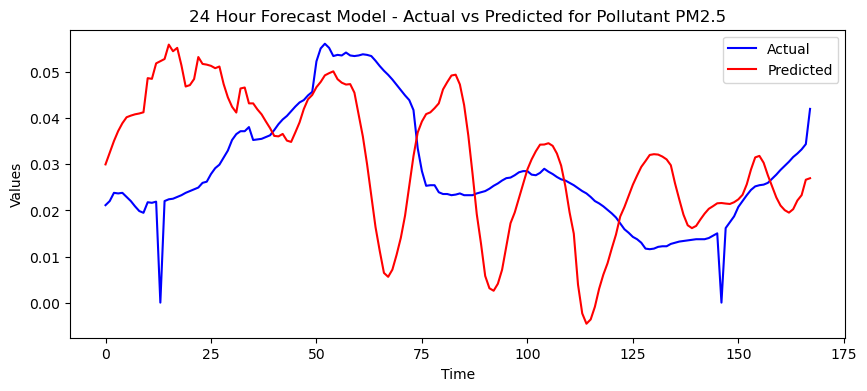

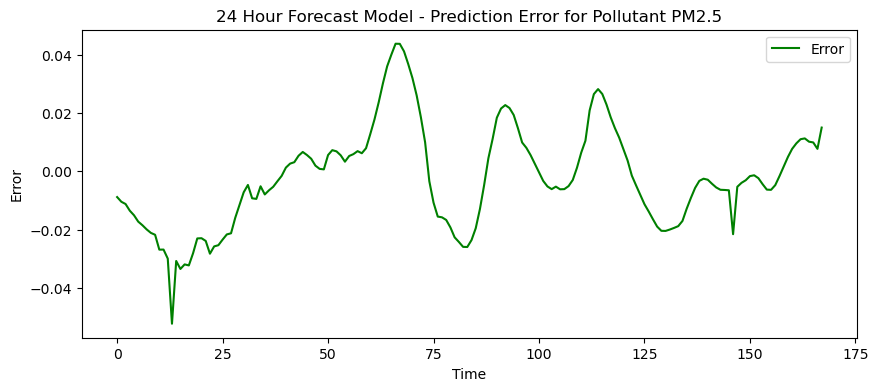

24 Hour Forecast Model - Pollutant PM10:
MAE: 0.02960, MSE: 0.00149, RMSE: 0.03858, R^2: -0.09490


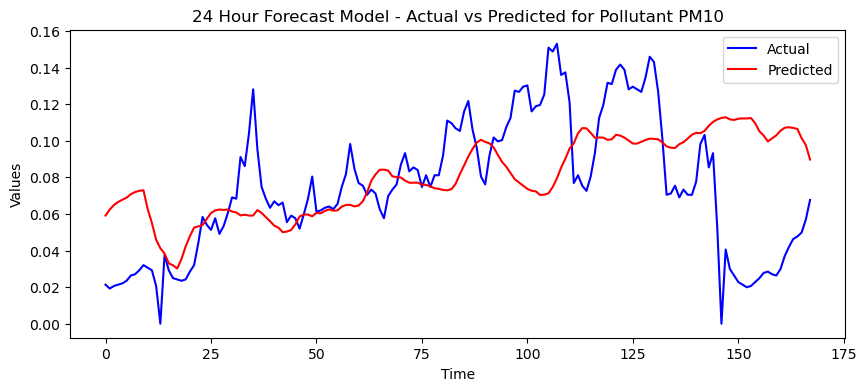

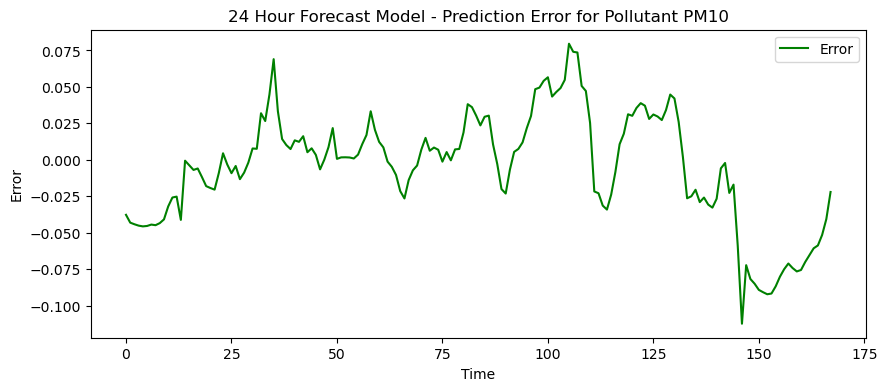

55/55 [==============================] - 2s 5ms/step
2 Hour Forecast Model - Pollutant PM2.5:
MAE: 0.04189, MSE: 0.00530, RMSE: 0.07283, R^2: 0.89342


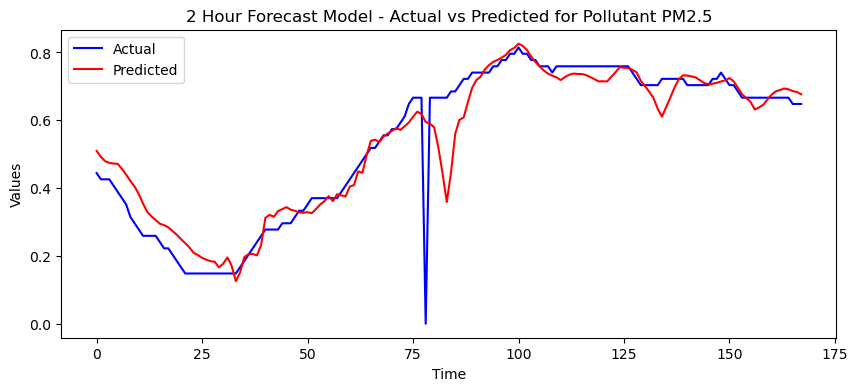

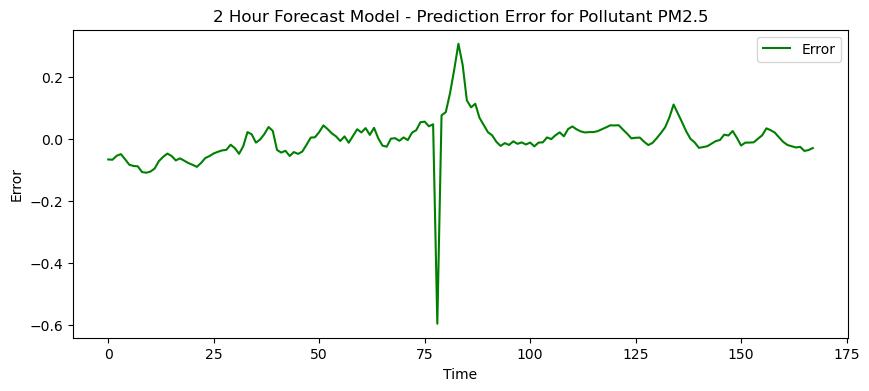

2 Hour Forecast Model - Pollutant PM10:
MAE: 0.04883, MSE: 0.00462, RMSE: 0.06796, R^2: 0.88467


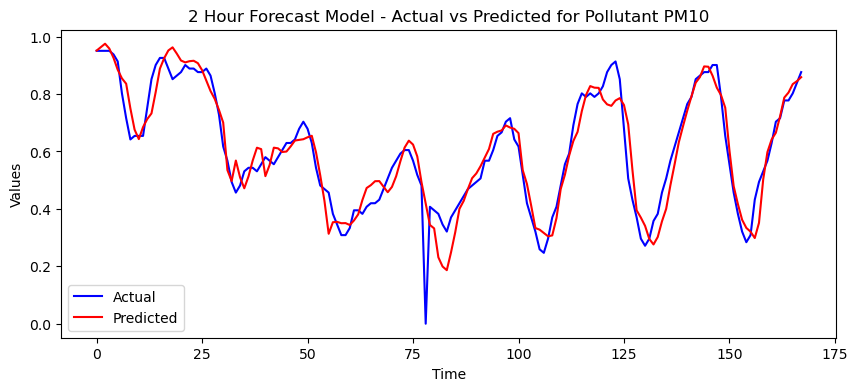

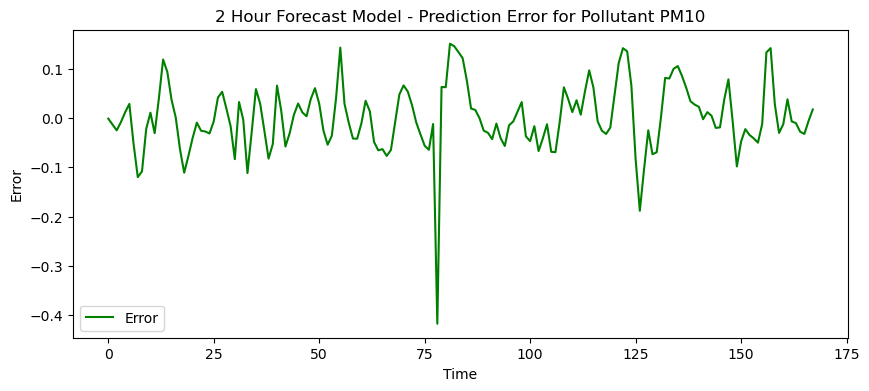

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def predict_and_evaluate(model, test_X, test_y, n_forecast_hours, model_name, sample_rate=1, start_index=0, end_index=None):
    predictions = model.predict(test_X)
    predictions = predictions.reshape((test_X.shape[0], n_forecast_hours, -1))
    actuals = test_y.reshape((test_y.shape[0], n_forecast_hours, -1))
    
    predictions = predictions[:, ::sample_rate, :]
    actuals = actuals[:, ::sample_rate, :]
    
    predictions = predictions[start_index:end_index]
    actuals = actuals[start_index:end_index]

    errors = actuals - predictions
    
    
    
    pollutants = ['PM2.5', 'PM10']
    n_pollutants = len(pollutants)
    
    for i in range(n_pollutants):
        mae = mean_absolute_error(actuals[:, :, i], predictions[:, :, i])
        mse = mean_squared_error(actuals[:, :, i], predictions[:, :, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(actuals[:, :, i], predictions[:, :, i])
        
        print(f'{model_name} - Pollutant {pollutants[i]}:')
        print(f'MAE: {mae:.5f}, MSE: {mse:.5f}, RMSE: {rmse:.5f}, R^2: {r2:.5f}')

        plt.figure(figsize=(10, 4))
        plt.plot(actuals[:, :, i].flatten(), label='Actual', color='blue')
        plt.plot(predictions[:, :, i].flatten(), label='Predicted', color='red')
        plt.title(f'{model_name} - Actual vs Predicted for Pollutant {pollutants[i]}')
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 4))
        plt.plot(errors[:, :, i].flatten(), label='Error', color='green')
        plt.title(f'{model_name} - Prediction Error for Pollutant {pollutants[i]}')
        plt.xlabel('Time')
        plt.ylabel('Error')
        plt.legend()
        plt.show()

model_24h = load_model('24h_forecast_model.h5')
model_2h = load_model('2h_forecast_model.h5')


predict_and_evaluate(model_24h, test_X_24h, test_y_24h, 24, "24 Hour Forecast Model", sample_rate=48, start_index=0, end_index=24*7)
predict_and_evaluate(model_2h, test_X_2h, test_y_2h, 2, "2 Hour Forecast Model", sample_rate=4, start_index=0, end_index=24*7)